#**Why Use SSL in Domain Adaptation?**


**Learn transferable features**:SSL helps extract domain-invariant features, making adaptation smoother.

**Reduce reliance on labeled target data**: Many DA scenarios lack labeled target domain samples, and SSL enables learning from unlabeled data.

**Improve robustness to domain shifts**: SSL enhances the model’s ability to generalize across domains by training it on pretext tasks.

#**Contrastive learning**

Contrastive learning is a powerful self-supervised technique for domain adaptation (DA) in PyTorch. It trains models to bring similar samples (positive pairs) closer and push different samples (negative pairs) apart, which helps in learning domain-invariant features.

We can use SimCLR-style contrastive learning to adapt MNIST (source) to USPS (target). The core idea is to train an encoder that learns shared features across both domains.

The purpose of contrastive learning is to learn meaningful representations by maximizing the similarity between positive pairs and minimizing the similarity between negative pairs—all without requiring labeled data.

**SimCLR (Simple Contrastive Learning Representation)**

Self-supervised learning framework designed for contrastive learning of visual representations. It simplifies contrastive learning by removing the need for specialized architectures or memory banks. The key components of SimCLR include

In this tutorial, we are designing a SimCLR-style model from scratch

The key components of SimCLR include:


1.   **Data Augmentation:** The composition of augmentations plays a crucial role   
    in defining effective predictive tasks.
2.   **Nonlinear Projection Head:** Introducing a learnable nonlinear  
    transformation between the representation and the contrastive loss improves the quality of learned representations.
3. **Large Batch Sizes & Training Steps:** Contrastive learning benefits from  
    larger batch sizes and extended training compared to supervised learning.



**Imports**

In [11]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, transforms
from torchvision.models import resnet18

from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [12]:
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
device

device(type='cuda')

**Data Processing**

In [13]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Random crop within 80-100% size
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Small rotation & translation
    transforms.RandomHorizontalFlip(),  # Although MNIST is digits, this helps for some USPS cases
    transforms.RandomGrayscale(p=0.2),  # Maintain grayscale consistency
    transforms.GaussianBlur(kernel_size=5),  # Slight blur for robustness
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
usps_dataset = datasets.USPS(root="./data", train=True, download=True, transform=transform)

In [14]:
len(mnist_dataset), len(usps_dataset)

(60000, 7291)

In [25]:
mnist_loader = DataLoader(mnist_dataset, batch_size=1006, shuffle=True, drop_last=True)
usps_loader = DataLoader(usps_dataset, batch_size=1006, shuffle=True, drop_last=True)

**Models**

In [16]:
#Base Encoder
class Encoder(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    resnet = resnet18(pretrained=True)
    self.encoder = nn.Sequential(*list(resnet.children())[:-1])

  def forward(self, x):
    if x.shape[1] == 1:
      x = x.repeat(1, 3, 1, 1)

    x = self.encoder(x)
    return x.view(x.size(0), -1)

In [17]:
#Projection Head
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=512, out_dim=128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, out_dim),
            nn.BatchNorm1d(out_dim),
            # nn.ReLU(),
            # nn.Dropout(0.3)

        )

    def forward(self, x):
        return self.projection(x)

**Loss Function**

The Normalized Temperature-scaled Cross Entropy Loss (NT-Xent) is a contrastive loss function used in self-supervised learning frameworks like SimCLR. It encourages representations of similar samples (positive pairs) to be closer while pushing different samples (negative pairs) further apart in the feature space.

In [18]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        batch_size = z1.size(0)

        # Normalize feature embeddings
        z1 = F.normalize(z1, p=2, dim=1)
        z2 = F.normalize(z2, p=2, dim=1)

        # Compute cosine similarity
        similarity_matrix = torch.mm(z1, z2.T)

        # Self-similarity mask
        mask = torch.eye(batch_size, dtype=torch.bool).to(z1.device)
        positives = similarity_matrix[mask].view(batch_size, 1)
        negatives = similarity_matrix[~mask].view(batch_size, -1)

        # Compute NT-Xent loss
        logits = torch.exp(positives / self.temperature) / torch.exp(negatives / self.temperature).sum(dim=-1)
        loss = -torch.log(logits).mean()

        return loss



**Training loop**

In [19]:
encoder = Encoder().to(device)
projection_head = ProjectionHead().to(device)

criterion = NTXentLoss(temperature=0.05)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(projection_head.parameters()), lr=0.0005)

In [20]:
num_epochs = 15
for epoch in range(num_epochs):
  encoder.train()
  projection_head.train()

  total_loss = 0.0

  for (mnist_batch , usps_batch) in zip(mnist_loader, usps_loader):
      mnist_inputs, _ = mnist_batch
      usps_inputs, _ = usps_batch

      mnist_inputs = mnist_inputs.to(device)
      usps_inputs = usps_inputs.to(device)

      # Forward pass
      # extract features
      mnist_features = encoder(mnist_inputs)
      usps_features = encoder(usps_inputs)

      # project features
      mnist_projected = projection_head(mnist_features)
      usps_projected = projection_head(usps_features)

      # contrastive loss
      loss = criterion(mnist_projected, usps_projected)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

Epoch [1/15], Loss: 64.6397
Epoch [2/15], Loss: 62.7882
Epoch [3/15], Loss: 62.3851
Epoch [4/15], Loss: 62.1030
Epoch [5/15], Loss: 61.8230
Epoch [6/15], Loss: 61.6062
Epoch [7/15], Loss: 61.6315
Epoch [8/15], Loss: 61.1587
Epoch [9/15], Loss: 60.8250
Epoch [10/15], Loss: 60.8131
Epoch [11/15], Loss: 60.7532
Epoch [12/15], Loss: 60.1479
Epoch [13/15], Loss: 59.9364
Epoch [14/15], Loss: 59.1212
Epoch [15/15], Loss: 57.7809


In [21]:
embeddings_list = []
domains_list = []  # Track source (MNIST=0) vs. target (USPS=1)

encoder.eval()
with torch.no_grad():
    for images, labels in mnist_loader:  # MNIST (Source Domain)
        images = images.cuda()
        embeddings = encoder(images).cpu()
        embeddings_list.append(embeddings)
        domains_list.append(torch.zeros(images.shape[0]))  # 0 for MNIST

    for images, _  in usps_loader:  # USPS (Target Domain, No Labels)
        images = images.cuda()
        embeddings = encoder(images).cpu()
        embeddings_list.append(embeddings)
        domains_list.append(torch.ones(images.shape[0]))  # 1 for USPS


# embeddings_list = torch.cat(embeddings_list, dim=0)
# domains_list = torch.cat(domains_list, dim=0)


In [22]:


def visualize_embeddings(embeddings, domains):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(embeddings.detach().cpu().numpy())

    plt.scatter(reduced[:, 0], reduced[:, 1], c=domains.numpy(), cmap="coolwarm", alpha=0.7)
    plt.colorbar(label="0=MNIST, 1=USPS")
    plt.title("t-SNE Visualization of Embeddings (Source vs. Target)")
    plt.show()


In [23]:
def find_nearest_neighbors(embeddings, domains):
    nn = NearestNeighbors(n_neighbors=3, metric="cosine")
    nn.fit(embeddings.cpu().numpy())

    distances, indices = nn.kneighbors(embeddings[:5].cpu().numpy())
    print(f"Nearest neighbors for first 5 USPS samples: {indices}")


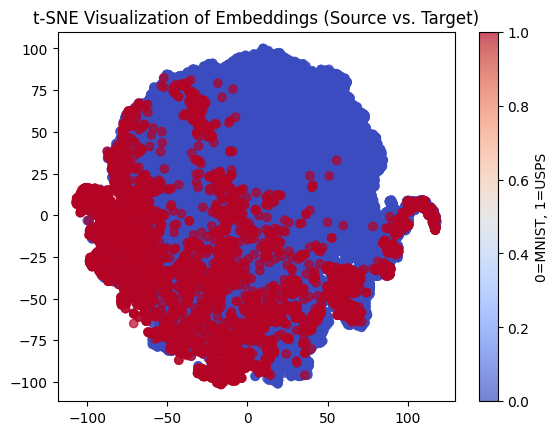

In [24]:
# Convert lists to tensors
embeddings_tensor = torch.cat(embeddings_list, dim=0)
domains_tensor = torch.cat(domains_list, dim=0)  # 0 (MNIST), 1 (USPS)

# t-SNE visualization with dataset colors
visualize_embeddings(embeddings_tensor, domains_tensor)
